# LASSO回归分析

## $\S1$ Configuration & Data Preparation

In [1]:
# Configuration
## Loading Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score


## Data Path
Path = "./Raw_Data_4.xlsx"
Dependent_Variable = "USD_index_Close"

## Param Grid
param_grid = {
    "model__alpha": np.logspace(-3, 3, 100)
}

## CV Scoring
scoring = {
    ### sklearn默认maximize the score, so we use prefix "neg"
    "RMSE": "neg_root_mean_squared_error",
    "MAE": "neg_mean_absolute_error",
    "R2": "r2"
}


In [2]:
# Data Preparation
## Loading Data
Data = pd.read_excel(Path, index_col="日期")
print("Data Size:", Data.shape)

## Data Split & Scale
### Split Features and Label
X = Data.drop(columns=[Dependent_Variable])
y = Data[[Dependent_Variable]]
# X,y = X.values, y.values

Data Size: (3223, 29)


In [3]:
### Split Train, Valid and Test Sets
train_size = int(len(Data) * 0.8)
X_train, X_test = X.iloc[:train_size, :], X.iloc[train_size:, :]
y_train, y_test = y.iloc[:train_size, :], y.iloc[train_size:, :]

#### Split Train Set into Tims Series
tsCV = TimeSeriesSplit(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(tsCV.split(X_train)):
    print(f"Fold {fold}: Train {len(train_idx)}, Test {len(test_idx)}")


Fold 0: Train 433, Test 429
Fold 1: Train 862, Test 429
Fold 2: Train 1291, Test 429
Fold 3: Train 1720, Test 429
Fold 4: Train 2149, Test 429


## $\S2$ Model Training & Predicting

In [4]:
## Generating Pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(random_state=42)),
]
)

## Model Selection
### Grid_Search with Pipe on Grid using TimeSeriesSplit CV on Train Set
gsCV = GridSearchCV(
    estimator = pipe,
    param_grid=param_grid,
    cv = tsCV,
    scoring = scoring,
    refit = "R2",
    n_jobs = -1,
    verbose = 2
)
gsCV.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,{'model__alpha': array([1.0000...00000000e+03])}
,scoring,"{'MAE': 'neg_mean_absolute_error', 'R2': 'r2', 'RMSE': 'neg_root_mean_squared_error'}"
,n_jobs,-1
,refit,'R2'
,cv,TimeSeriesSpl...est_size=None)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [5]:
### printing best model
#### Best Hyper Parameters:
print("Grid Search 最佳参数: ", gsCV.best_params_)
print("对应的(CV平均)最优R2:", gsCV.best_score_)

#### CV Results:
result = pd.DataFrame(gsCV.cv_results_)
cols_to_show = ["param_model__alpha", "mean_test_RMSE", "mean_test_MAE", "mean_test_R2"]
result["mean_test_MAE"] = -result["mean_test_MAE"]
result["mean_test_RMSE"] = -result["mean_test_RMSE"]
print(result[cols_to_show].sort_values(by="mean_test_R2", ascending=False).head(10))

Grid Search 最佳参数:  {'model__alpha': np.float64(1000.0)}
对应的(CV平均)最优R2: -0.00200915602612779
    param_model__alpha  mean_test_RMSE  mean_test_MAE  mean_test_R2
99         1000.000000        0.005104       0.003900     -0.002009
98          869.749003        0.005107       0.003905     -0.004257
97          756.463328        0.005112       0.003911     -0.006707
96          657.933225        0.005117       0.003917     -0.009336
95          572.236766        0.005122       0.003922     -0.012115
94          497.702356        0.005127       0.003928     -0.015016
93          432.876128        0.005133       0.003934     -0.018010
92          376.493581        0.005139       0.003940     -0.021068
91          327.454916        0.005145       0.003946     -0.024160
90          284.803587        0.005151       0.003952     -0.027261


In [6]:
## Model Prediction
### 在gsCV中，refit已经选取了最优模型，Pipe在整个训练集上进行了重新训练
best_ridge = gsCV.best_estimator_
best_ridge.named_steps["model"].alpha
y_pred = best_ridge.predict(X_test)

Text(0.5, 1.0, 'LASSO Regression Prediction')

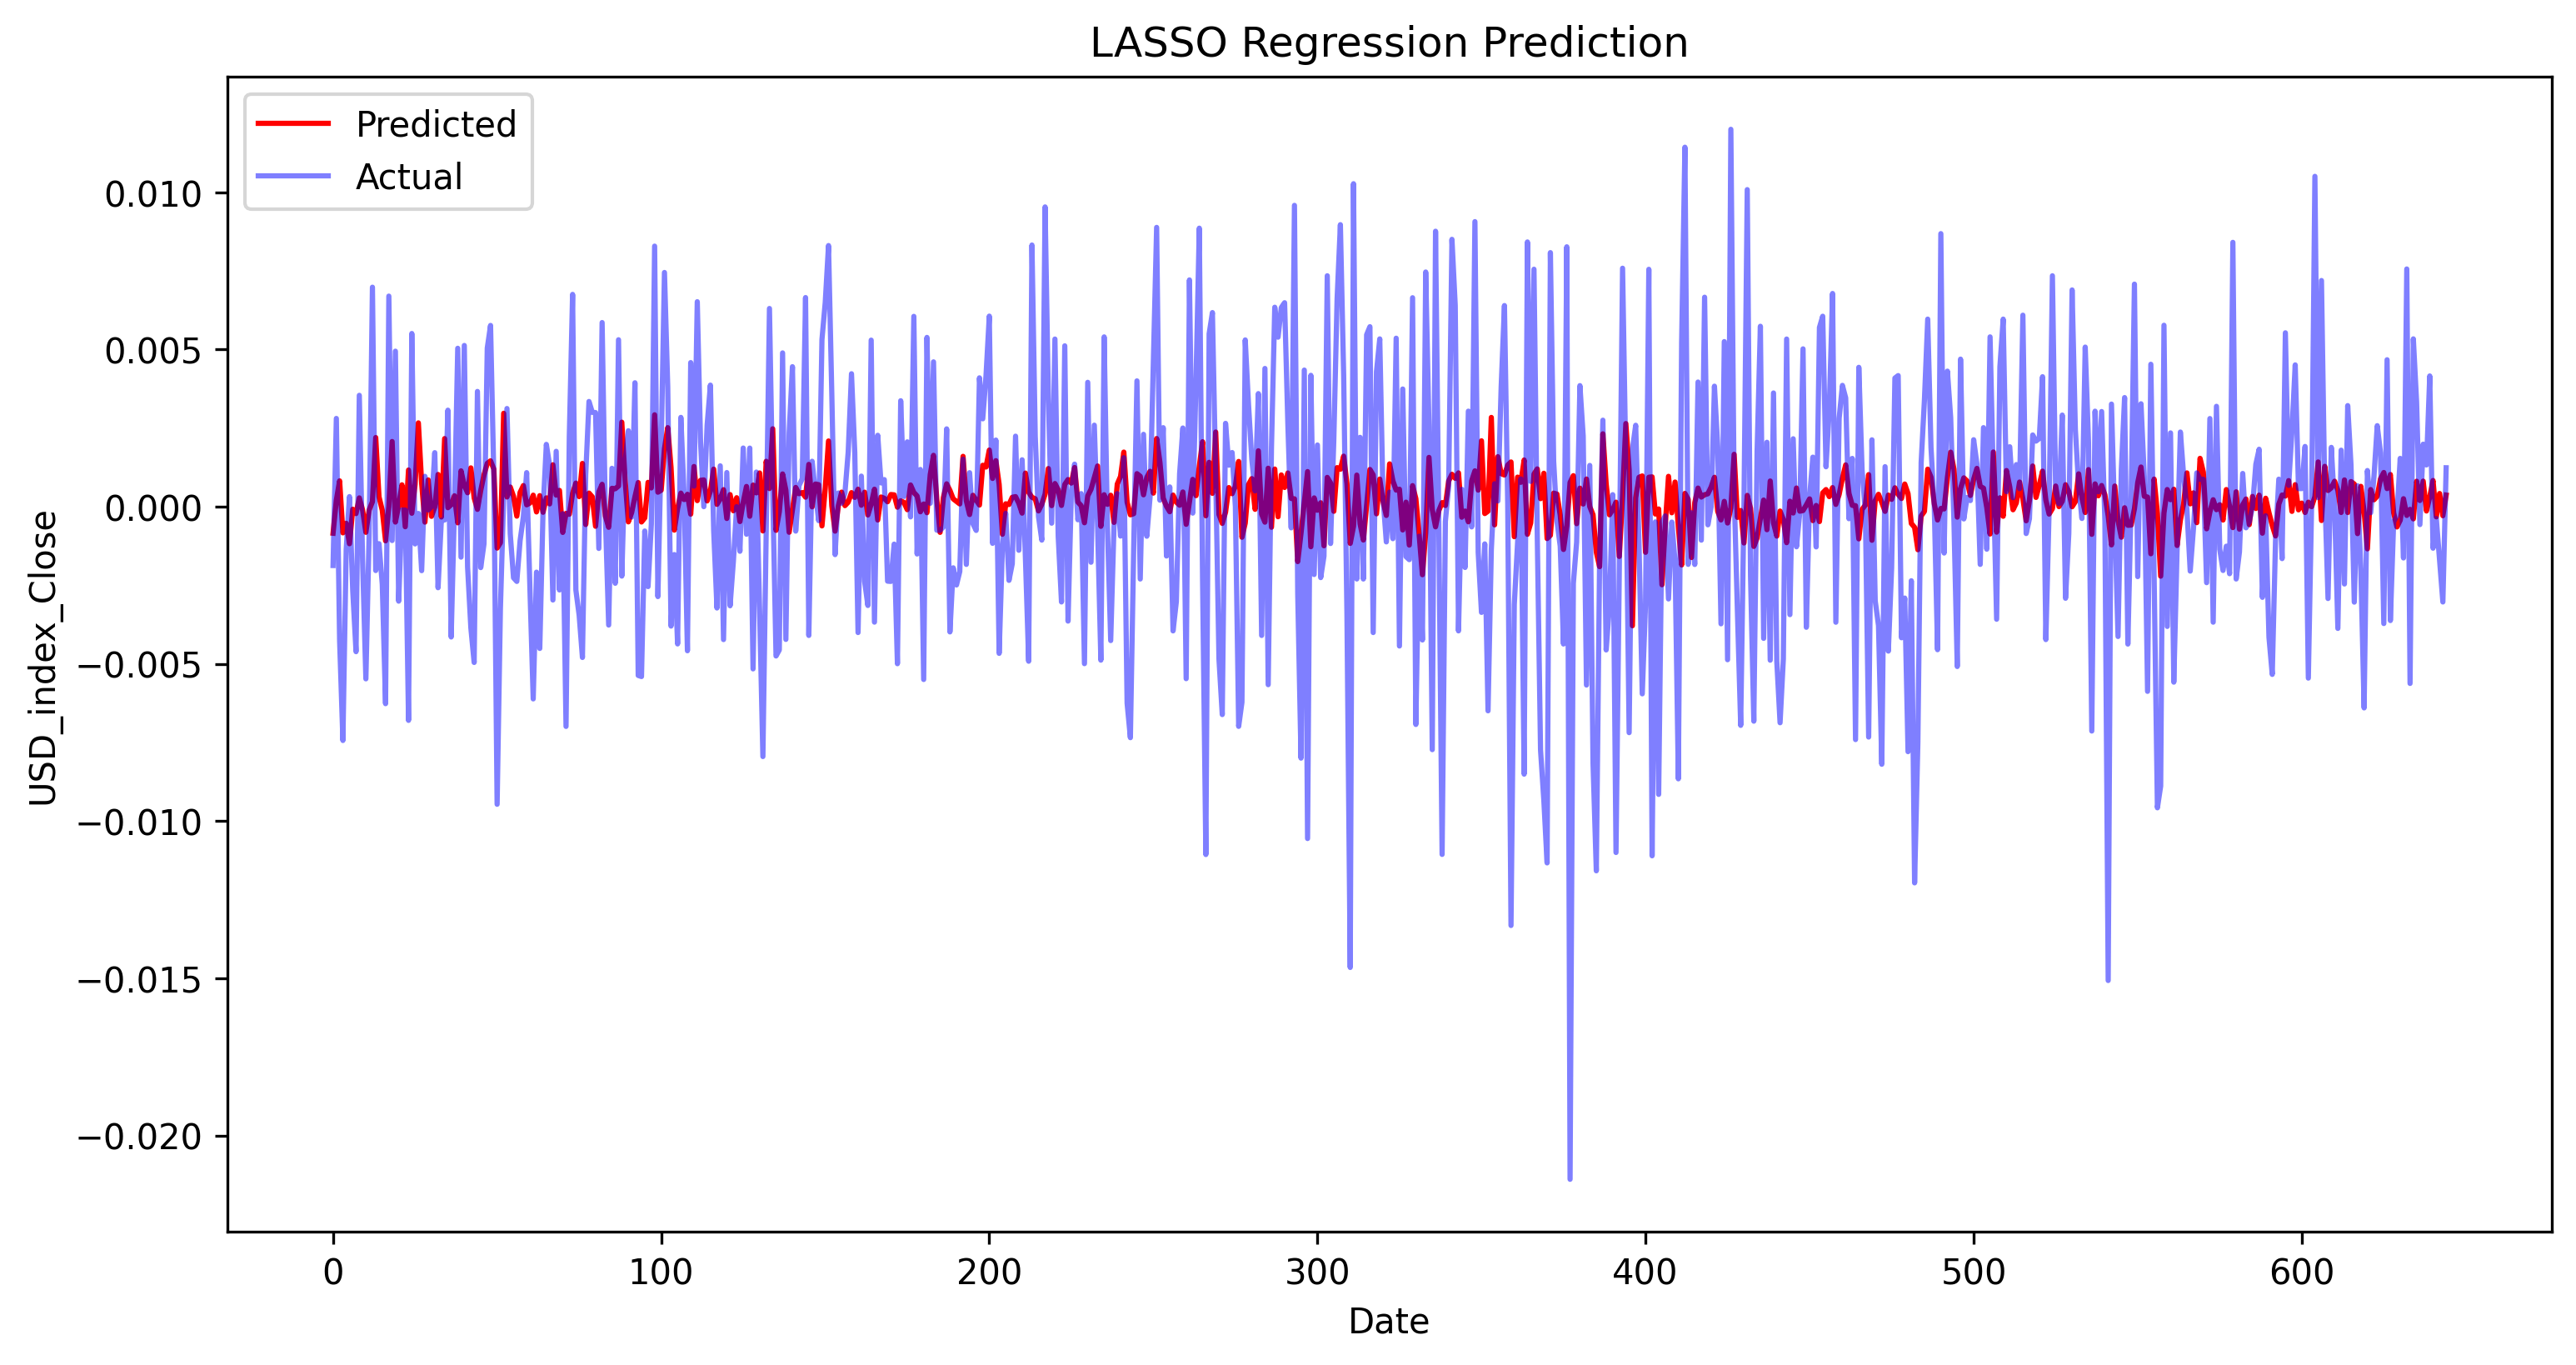

In [8]:
### Prediction Visualization
fig, ax1 = plt.subplots(figsize=(12,6), dpi=300)
ax1.plot(y_pred, label="Predicted", color="red")
ax1.plot(y_test.values, label="Actual", color="blue", alpha=0.5)
ax1.set_xlabel("Date")
ax1.set_ylabel("USD_index_Close")
ax1.legend()
ax1.set_title("LASSO Regression Prediction")

## $\S3$ Model Evaluation & Explanation

In [9]:
## Model Evaluation
# 4.2 计算测试集指标
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = root_mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print("=== 测试集表现 ===")
print(f"MAE  : {test_mae:.6f}")
print(f"RMSE  : {test_rmse:.6f}")
print(f"R^2  : {test_r2:.6f}")

=== 测试集表现 ===
MAE  : 0.003277
RMSE  : 0.004268
R^2  : 0.011913


In [10]:
best_ridge.named_steps["model"].coef_

array([-9.99089980e-06,  4.84121130e-04,  2.29859465e-05, -3.79993261e-05,
       -3.09551659e-04, -4.43739443e-05,  4.72109216e-06,  4.42392287e-05,
        1.57735346e-05,  5.47937259e-05, -2.81984031e-05,  1.43749286e-04,
       -2.29533829e-04, -1.60100767e-04,  9.00946302e-05, -1.61704675e-04,
       -1.03856377e-04, -1.56690223e-05,  5.57405293e-05, -2.60227787e-05,
       -4.79541637e-05,  4.42580303e-05, -1.09246083e-06, -2.11367530e-05,
       -1.96439160e-04, -8.52489001e-05, -1.62418738e-05,  2.14860474e-04])